In [33]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

In [34]:
# ==== 1. Load và chuẩn bị dữ liệu ====
df = pd.read_csv('D:/ALL_Python/EXAMPLE_DOAN/BT_MHTG/CUOI_KY/Ha_Nhat_Doan_4554100017/dataset/ECL.csv')
data = df['MT_001'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [50]:
# ==== 2. Tạo chuỗi đầu vào (dùng cho cả XGBoost và LSTM) ====
def create_sequences(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 6240
X_seq, y_seq = create_sequences(data_scaled, lag)

In [51]:
# ==== 3. Huấn luyện mô hình XGBoost trên đặc trưng thống kê từ dữ liệu chuỗi ====
X_features = X_seq.reshape(X_seq.shape[0], -1)
xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=3, learning_rate=0.8,  # Tốc độ học: kiểm soát kích thước bước thu nhỏ khi tối ưu hóa
    subsample=0.8,      # Tỷ lệ mẫu con: tỷ lệ các mẫu được lấy ngẫu nhiên để huấn luyện mỗi cây
    colsample_bytree=0.8, # Tỷ lệ cột mẫu con: tỷ lệ các đặc trưng (cột) được lấy ngẫu nhiên để huấn luyện mỗi cây
    gamma=0,            # Giá trị tối thiểu của việc mất mát cần thiết để tạo thêm một phân chia trên một nút lá của cây.
    reg_alpha=0,        # L1 regularization (Lasso) cho các trọng số.
    reg_lambda=1,       # L2 regularization (Ridge) cho các trọng số.
    random_state=42,    # Hạt giống ngẫu nhiên để đảm bảo khả năng tái tạo kết quả
    n_jobs=-1           # Số lượng luồng song song để chạy XGBoost. -1 sử dụng tất cả các lõi có sẵn.
) 
xgb_model.fit(X_features, y_seq)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.8, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=-1, num_parallel_tree=None, ...)

In [52]:
# ==== 4. Trích đặc trưng từ XGBoost cho đầu vào LSTM ====
xgb_features = xgb_model.predict(X_features).reshape(-1, 1)
X_lstm_input = np.concatenate((X_seq[:, -1, :], xgb_features), axis=1)
X_lstm_input = X_lstm_input.reshape(-1, 1, 2)
y_lstm = y_seq

In [53]:
# ==== 5. Định nghĩa mô hình LSTM ====
class XGBoostLSTM(nn.Module):
    def __init__(self):
        super(XGBoostLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XGBoostLSTM().to(device)

In [54]:
# ==== 6. Train mô hình LSTM ====
X_tensor = torch.tensor(X_lstm_input, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_lstm, dtype=torch.float32).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")

Epoch 1: Loss = 4.2599
Epoch 2: Loss = 0.6653
Epoch 3: Loss = 0.3133
Epoch 4: Loss = 0.1605
Epoch 5: Loss = 0.1348
Epoch 6: Loss = 0.1177
Epoch 7: Loss = 0.1037
Epoch 8: Loss = 0.0936
Epoch 9: Loss = 0.0878
Epoch 10: Loss = 0.0849
Epoch 11: Loss = 0.0837
Epoch 12: Loss = 0.0832
Epoch 13: Loss = 0.0830
Epoch 14: Loss = 0.0829
Epoch 15: Loss = 0.0827
Epoch 16: Loss = 0.0827
Epoch 17: Loss = 0.0826
Epoch 18: Loss = 0.0825
Epoch 19: Loss = 0.0824
Epoch 20: Loss = 0.0823


In [55]:
# ==== 7. Dự báo lại toàn bộ tập dữ liệu ====
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()

In [56]:
# ==== 8. Đưa dữ liệu về dạng gốc ====
y_true = scaler.inverse_transform(y_seq)
y_pred_inv = scaler.inverse_transform(y_pred)

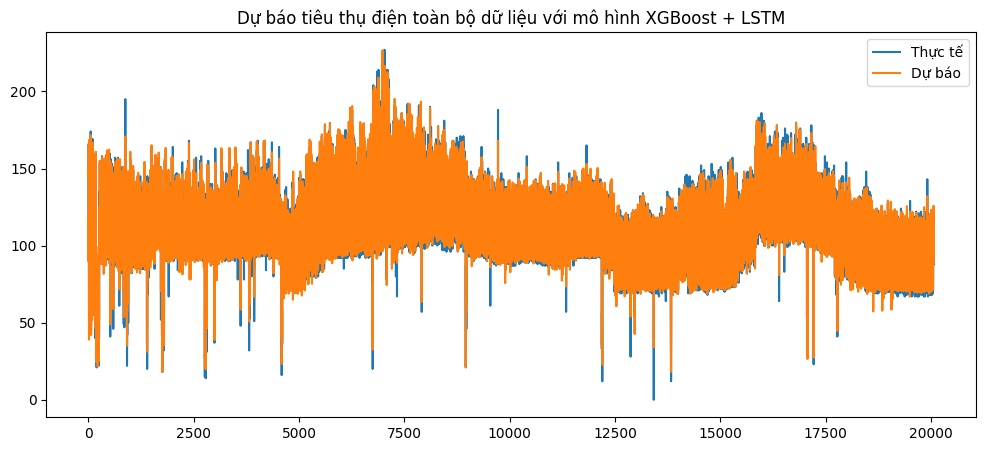

In [57]:
# ==== 9. Vẽ biểu đồ kết quả ====
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Thực tế')
plt.plot(y_pred_inv, label='Dự báo')
plt.legend()
plt.title('Dự báo tiêu thụ điện toàn bộ dữ liệu với mô hình XGBoost + LSTM')
plt.show()

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Độ đo
mae = mean_absolute_error(y_true, y_pred_inv)
mse = mean_squared_error(y_true, y_pred_inv)
rmse = np.sqrt(mse)
mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred_inv[mask]) / y_true[mask])) * 100
r2 = r2_score(y_true, y_pred_inv)

# In kết quả
print(f"📊 Kết quả đánh giá mô hình XGBoost + LSTM trên toàn bộ dữ liệu:")
print(f"🔹 MAE  (Mean Absolute Error):       {mae:.4f}")
print(f"🔹 MSE  (Mean Squared Error):        {mse:.4f}")
print(f"🔹 RMSE (Root Mean Squared Error):   {rmse:.4f}")
print(f"🔹 MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"🔹 R²   (R-squared):                 {r2:.4f}")

📊 Kết quả đánh giá mô hình XGBoost + LSTM trên toàn bộ dữ liệu:
🔹 MAE  (Mean Absolute Error):       3.6045
🔹 MSE  (Mean Squared Error):        22.8890
🔹 RMSE (Root Mean Squared Error):   4.7842
🔹 MAPE (Mean Absolute % Error):     3.43%
🔹 R²   (R-squared):                 0.9625


In [44]:
time_index = df['date'][-len(y_true):].reset_index(drop=True)

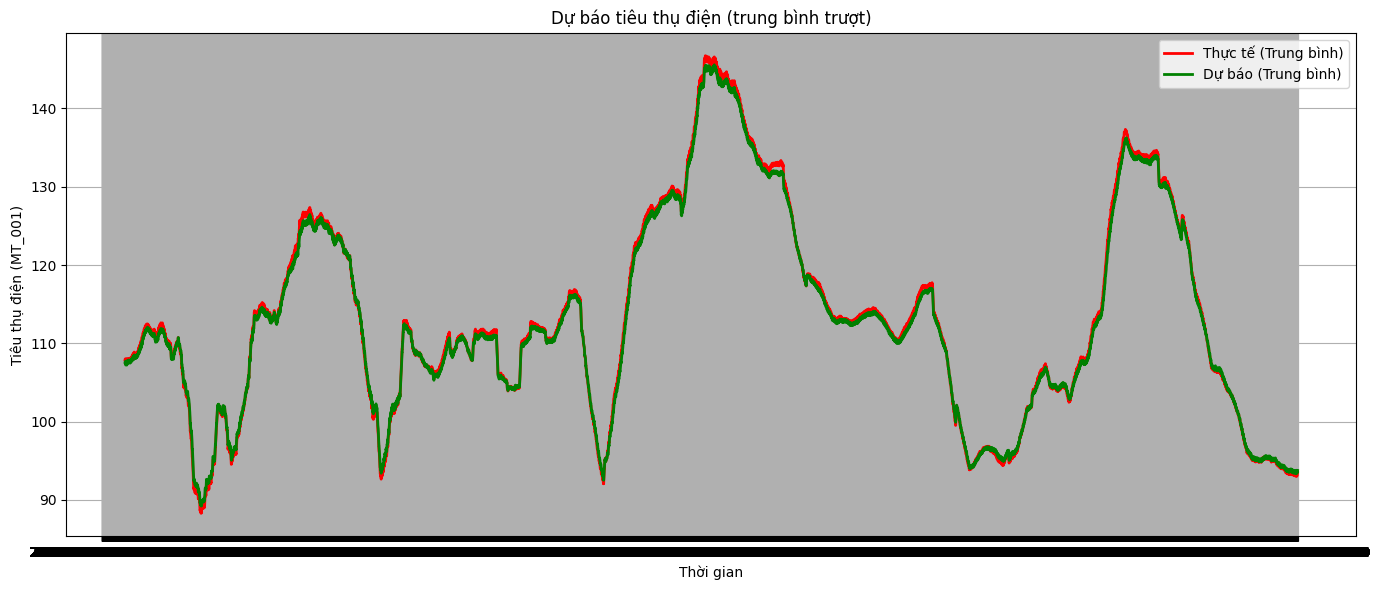

In [45]:
# Độ dài cửa sổ trượt
window_size = 500

# Tạo chuỗi trung bình trượt
y_true_ma = pd.Series(y_true.ravel()).rolling(window=window_size).mean()
y_pred_ma = pd.Series(y_pred_inv.ravel()).rolling(window=window_size).mean()


# Vẽ biểu đồ trung bình trượt
plt.figure(figsize=(14, 6))
plt.plot(time_index, y_true_ma, label='Thực tế (Trung bình)', color='red', linewidth=2)
plt.plot(time_index, y_pred_ma, label='Dự báo (Trung bình)', color='green', linewidth=2)

plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ điện (MT_001)')
plt.title('Dự báo tiêu thụ điện (trung bình trượt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

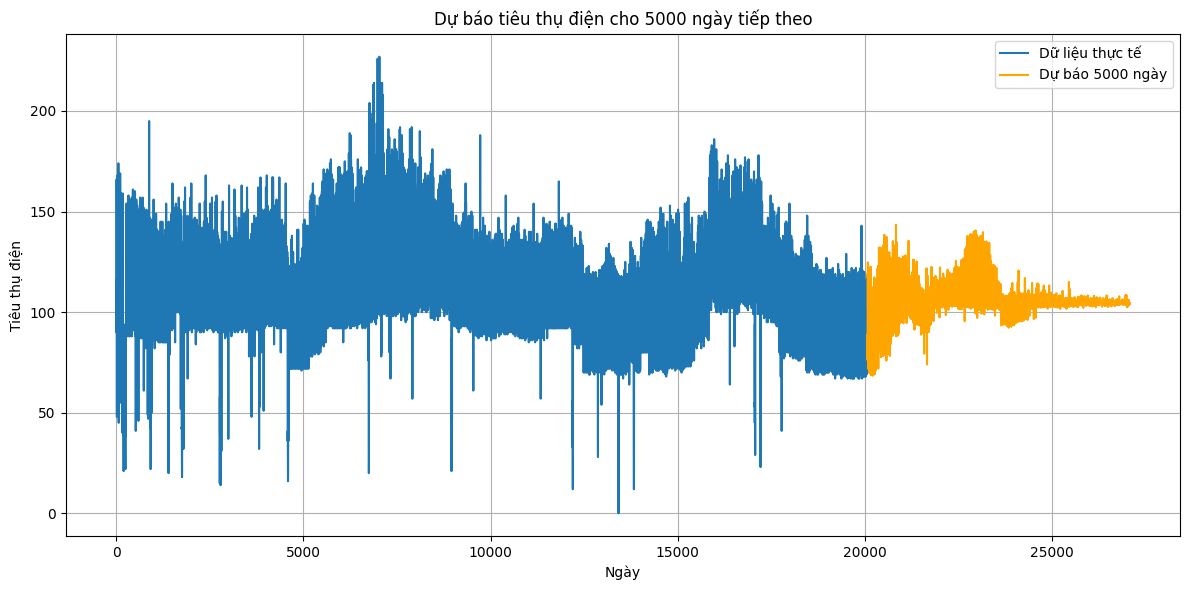

In [62]:
# ==== 10. Dự báo 500 ngày tiếp theo ====
forecast_steps = 7000
last_seq = X_seq[-1]  # Dãy input cuối cùng (dạng [lag, 1])
predictions = []

for _ in range(forecast_steps):
    # Dự báo với XGBoost
    xgb_input = last_seq.reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input).reshape(-1, 1)

    # Tạo input cho LSTM
    lstm_input = np.concatenate((last_seq[-1:], xgb_pred), axis=1).reshape(1, 1, 2)
    lstm_input_tensor = torch.tensor(lstm_input, dtype=torch.float32).to(device)

    # Dự báo bằng LSTM
    model.eval()
    with torch.no_grad():
        lstm_pred = model(lstm_input_tensor).cpu().numpy()

    predictions.append(lstm_pred.item())

    # Cập nhật chuỗi đầu vào mới bằng cách thêm dự báo vừa rồi
    new_point = np.array([[lstm_pred.item()]])
    last_seq = np.vstack((last_seq[1:], new_point))

# ==== 11. Chuyển về giá trị gốc và hiển thị ====
forecast_scaled = np.array(predictions).reshape(-1, 1)
forecast_original = scaler.inverse_transform(forecast_scaled)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_true)), y_true, label='Dữ liệu thực tế')
plt.plot(range(len(y_true), len(y_true) + forecast_steps), forecast_original, label='Dự báo 5000 ngày', color='orange')
plt.title('Dự báo tiêu thụ điện cho 5000 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Tiêu thụ điện')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


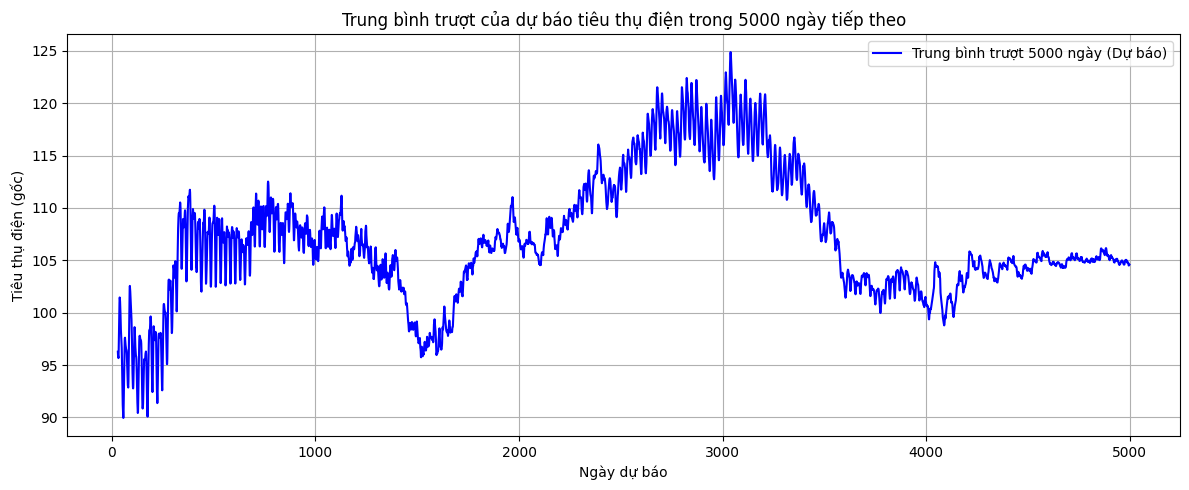

In [60]:
# ==== Trung bình trượt của dữ báo ====
window_size = 30  # Bạn có thể thay đổi kích thước cửa sổ nếu muốn
forecast_ma = pd.Series(forecast_original.ravel()).rolling(window=window_size).mean()

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.plot(forecast_ma, label=f'Trung bình trượt 5000 ngày (Dự báo)', color='blue')
plt.title(f'Trung bình trượt của dự báo tiêu thụ điện trong 5000 ngày tiếp theo')
plt.xlabel('Ngày dự báo')
plt.ylabel('Tiêu thụ điện (gốc)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecast_horizons = [12, 24, 36, 48]
metrics = {'mae': [], 'mse': [], 'rmse': [], 'mape': [], 'r2': []}

for S in forecast_horizons:
    n_samples = 100  # Giới hạn số mẫu để giảm thời gian tính toán
    maes, mses, rmses, mapes, r2s = [], [], [], [], []

    for i in range(n_samples):
        if i + S + 1 >= len(X_seq):
            break

        x_input = X_seq[i]
        y_target = y_seq[i+1:i+1+S].reshape(-1, 1)

        predictions = []
        last_seq = x_input.copy()

        for _ in range(S):
            xgb_input = last_seq.reshape(1, -1)
            xgb_pred = xgb_model.predict(xgb_input).reshape(-1, 1)

            lstm_input = np.concatenate((last_seq[-1:], xgb_pred), axis=1).reshape(1, 1, 2)
            lstm_input_tensor = torch.tensor(lstm_input, dtype=torch.float32).to(device)

            model.eval()
            with torch.no_grad():
                lstm_pred = model(lstm_input_tensor).cpu().numpy()

            predictions.append(lstm_pred.item())
            last_seq = np.vstack((last_seq[1:], [[lstm_pred.item()]]))

        # Chuyển về dạng gốc
        forecast_scaled = np.array(predictions).reshape(-1, 1)
        forecast_original = scaler.inverse_transform(forecast_scaled)
        y_true_original = scaler.inverse_transform(y_target)

        # Đánh giá
        mae = mean_absolute_error(y_true_original, forecast_original)
        mse = mean_squared_error(y_true_original, forecast_original)
        rmse = np.sqrt(mse)
        mask = y_true_original != 0
        mape = np.mean(np.abs((y_true_original[mask] - forecast_original[mask]) / y_true_original[mask])) * 100
        r2 = r2_score(y_true_original, forecast_original)

        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)
        mapes.append(mape)
        r2s.append(r2)

    # Lưu trung bình cho mỗi S
    metrics['mae'].append(np.mean(maes))
    metrics['mse'].append(np.mean(mses))
    metrics['rmse'].append(np.mean(rmses))
    metrics['mape'].append(np.mean(mapes))
    metrics['r2'].append(np.mean(r2s))

# ==== In kết quả trung bình toàn bộ horizon ====
print("📊 Trung bình cộng các độ dài dự báo (S = 12, 24, 36, 48):")
print(f"🔹 MAE  (Mean Absolute Error):       {np.mean(metrics['mae']):.4f}")
print(f"🔹 MSE  (Mean Squared Error):        {np.mean(metrics['mse']):.4f}")
print(f"🔹 RMSE (Root Mean Squared Error):   {np.mean(metrics['rmse']):.4f}")
print(f"🔹 MAPE (Mean Absolute % Error):     {np.mean(metrics['mape']):.2f}%")
print(f"🔹 R²   (R-squared):                 {np.mean(metrics['r2']):.4f}")


📊 Trung bình cộng các độ dài dự báo (S = 12, 24, 36, 48):
🔹 MAE  (Mean Absolute Error):       19.7956
🔹 MSE  (Mean Squared Error):        720.4262
🔹 RMSE (Root Mean Squared Error):   26.2894
🔹 MAPE (Mean Absolute % Error):     20.89%
🔹 R²   (R-squared):                 0.3640
